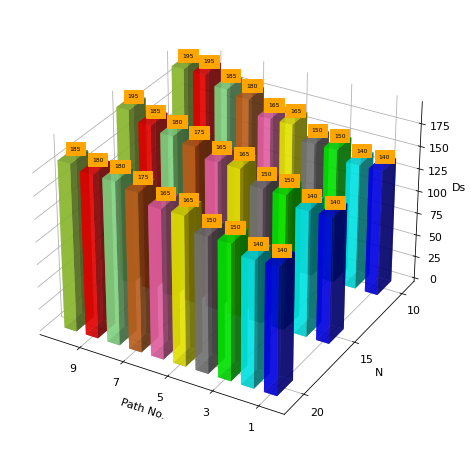

In [5]:
import numpy as np
import random
import math
import copy
from Draw_3D_chart import BarChart

class Solution(object):
    def __init__(self):
        self.path = []
        self.code = []
        self.fitness = float('inf')
        self.velocity = []
        self.best_local_code = []
        self.best_local_fitness = float('inf')


class BMA:

    def __init__(self, src, dst, N, Max, K_paths, w, c1, c2):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.best_global_solution = Solution()
        self.population = [self.CreateSolution() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.values = []
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('../../metric_data.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateSolution(self):
        newSolution = Solution()
        path=[]
        code = []
        while(len(path)==0):
            code.clear()
            path.clear()
            code = copy.deepcopy([random.uniform(-1,1) for i in range(len(self.switches))])
            path = copy.deepcopy(self.Decode(code))
        newSolution.code = copy.deepcopy(code)
        newSolution.path = copy.deepcopy(path)
        newSolution.velocity = [random.uniform(-1,1) for i in range(len(self.switches))]
        newSolution.fitness = self.Evaluate(newSolution.path)
        newSolution.best_local_code= copy.deepcopy(code)
        newSolution.best_local_fitness = newSolution.fitness
        if(newSolution.best_local_fitness<=self.best_global_solution.fitness):
            self.best_global_solution.code = copy.deepcopy(newSolution.best_local_code)
            self.best_global_solution.fitness = copy.deepcopy(newSolution.best_local_fitness)
        return newSolution
    
    def Decode(self,code):
        path = []
        path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                break
            switch_min = 1
            min = float('inf')
            for switch in neighbor_switches:
                if(code[switch-1] <= min):
                    min = code[switch-1]
                    switch_min = switch
            current_switch = switch_min
            path.append(current_switch)
        return path

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def Normalize(self,code):
        code_2 = copy.deepcopy(code)
        mn = min(code_2)
        mx = max(code_2)
        for j in range(len(self.switches)):
            code[j] = -1+2*(code_2[j]-mn)/(mx-mn)
        return code
    
    def UpdateLocalGlobal(self,solution):
        if(solution.fitness<=solution.best_local_fitness):
            solution.best_local_code = copy.deepcopy(solution.code)
            solution.best_local_fitness = solution.fitness
            if(solution.best_local_fitness<=self.best_global_solution.fitness):
                self.best_global_solution.code = copy.deepcopy(solution.best_local_code)
                self.best_global_solution.fitness = copy.deepcopy(solution.best_local_fitness)

    def UpdateVelocityPosition(self):
        for i in range(self.N):
            velocity = copy.deepcopy(self.population[i].velocity)
            code = copy.deepcopy(self.population[i].code)
            path = []
            while(len(path)==0):
                for j in range(len(self.switches)):
                    r0 = np.random.rand()
                    r1 = np.random.rand()
                    r2 = np.random.rand()
                    v1 = self.c1*r1*(self.population[i].best_local_code[j]-self.population[i].code[j])
                    v2 = self.c2*r2*(self.best_global_solution.code[j]-self.population[i].code[j])
                    velocity[j] = self.w*r0*self.population[i].velocity[j] + v1 + v2
                velocity = self.Normalize(velocity)
                for j in range(len(self.switches)):
                    code[j] = self.population[i].code[j] + velocity[j]
                code = self.Normalize(code)
                path = copy.deepcopy(self.Decode(code))
            self.population[i].velocity = copy.deepcopy(velocity)
            self.population[i].code = copy.deepcopy(code)
            self.population[i].path = copy.deepcopy(path)
            self.population[i].fitness = self.Evaluate(self.population[i].path)
            self.UpdateLocalGlobal(self.population[i])
            

    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for member in condidate:
                if(tuple(member.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for solution in self.best:
                if(tuple(solution.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for x in range(len(self.best)):
            self.values.append(self.best[x].fitness)
        file1 = open('../../wires.txt','r')
        Lines = file1.readlines()
        count = 0
        for line in Lines:
            if(line.strip()[0] == "N"):
                count += 1
        file1.close()
        f1 = open("../../wires.txt","a")
        if(count==3):
            f1.truncate(0)
        stt_0 = ",".join(["N = "+str(self.N),"Max = "+str(self.Max),"w = "+str(self.w),"c1 = "+str(self.c1),"c2 = "+str(self.c2)]) + "\n"
        f1.write(stt_0)
        for i in range(len(self.best)):
            stt = ",".join(str(self.weight_map[self.best[i].path[x]][self.best[i].path[x+1]]) for x in range(len(self.best[i].path) - 1))
            stt= stt+"\n"
            f1.write(stt)
        f1.close()

    def Do(self):
        for i in range(self.Max):
            self.UpdateVelocityPosition()
            self.MemorizeCondidates()
        self.GetBest()
        
N = [10,15,20]
Max = 100
K_paths = 10
w = 2
c1 = 1
c2 = 0.1
src = 2
dst = 7
st = "al_BMA"
pr = [str(i) for i in N]
pr.reverse()
pr.append("N")
alg = BMA(src,dst,N[0],Max,K_paths,w,c1,c2)
alg.Do()
alg1 = BMA(src,dst,N[1],Max,K_paths,w,c1,c2)
alg1.Do()
alg2 = BMA(src,dst,N[2],Max,K_paths,w,c1,c2)
alg2.Do()
chart = BarChart(alg2.values,alg1.values,alg.values,st,pr)
chart.Do()
f=open("../../demo.txt","w")
f.truncate(0)
for i in range(len(alg2.best)):
    stt = ",".join(str(x) for x in alg2.best[i].path)
    stt= stt+","+str(alg2.best[i].fitness)+"\n"
    f.write(stt)
f.close()